# Fishing Basics

This Notebook will walk through the very basic steps of how to load up data, set up the rotation profile and start extracting spectra.

## Get the Data

For this we use the lovely data of 12CO J=3-2 emission from TW Hya, presented in [Huang et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...852..122H). This can downloaded from the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PXDKBC), we'll need the `dataverse_TWHya_CO_cube.fits` cube. Make sure it's in the same directory as this Notebook if you want to run it.

TW Hya is a good source to start with as it's near face-on inclination mean that we can assume that the disk is essentially a razor thing 2D disk. In addition the geomtrical parameters are very well known.

## Load the Data

Loading the data is as simple as firing up `GoFish` and passing it the path of the fits cube to `imagecube`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gofish.gofish.gofish import imagecube  # change this!

In [2]:
cube = imagecube('/Users/rteague/Projects/TWHya_Kinematics/Data/ALMA/Huang/dataverse_TWHya_CO_cube.fits', clip=5.0)

You can use the `clip` argument here to trim down your image cube to a field of view which may speed up calculations.

## Coordinate System

We can deproject from a pixel position, $(x_{\rm pix},\, y_{\rm pix})$, to a disk-frame coordinate, $(r,\,\theta)$. These transforms are done through the `imagecube.disk_coords` function which takes geometrical properties of the disk and returns the disk coordinates.

For TW Hya we know that `i=5.0` and `PA=152.0` (both in degrees), so we can return the $(r,\,\theta)$ values for each pixel. We also assume the source is centered in the image such that `x0=0.0` and `y0=0.0`.

In [3]:
rvals, tvals, _ = cube.disk_coords(x0=0.0, y0=0.0, inc=5.0, PA=152.0)

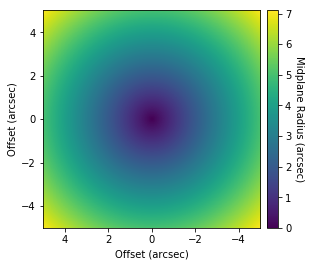

In [4]:
fig, ax = plt.subplots()
im = ax.imshow(rvals, origin='lower', extent=cube.extent, vmin=0.0)
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Midplane Radius (arcsec)', rotation=270, labelpad=13)

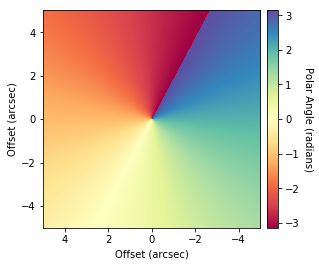

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(tvals, origin='lower', extent=cube.extent, cmap='Spectral')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Polar Angle (radians)', rotation=270, labelpad=13)

The polar angle, $\theta$, in is radians, and runs from $-\pi$ to $\pi$ in an eastward direction with $\theta = 0$ aligning with the red-shifted major axis of the disk. Note that this is _not_ the same as the position angle, particualrly when the disk is highly inclined.

You'll notice that when calling `disk_coords` we left space for three returned parameters. The third is $z$, the height above the midplane. By default, we assume that the disk is a razor-thin 2D disk. However, with the high spatial resolution afford by ALMA, it is now possible to resolve the vertical structure of the disk as well (see [Rosenfeld et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...774...16R) for a nice demonstration of this for HD 163296).

For this, we assume that the emission surface is described via,

$$
z(r) = z_0 \times \left( \frac{r}{1^{\prime\prime}} \right)^{\psi} + z_1 \times \left( \frac{r}{1^{\prime\prime}} \right)^{\varphi}
$$

where the second term acts as a 'correction' term in order to account for the drop in emission surface expected due to the drop in gas surface density at large radii. `disk_coords` also accepts the parameters `z0, psi, z1, phi` to describe the emission height. If we take `psi=1.0`, we recover a conical disk, while `psi > 1.0` gives a flared disk surface.

As an example, we increase the inclination to make the changes due to the height more noticable.

In [6]:
rvals, tvals, zvals = cube.disk_coords(inc=50.0, PA=152.0, z0=0.3, psi=1.0)

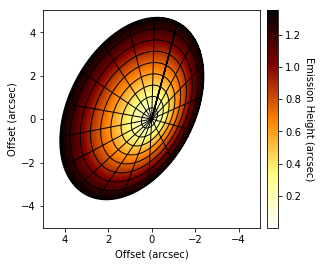

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(np.where(rvals <= 4.5, zvals, np.nan), origin='lower', extent=cube.extent, cmap='afmhot_r')
ax.contour(cube.xaxis, cube.yaxis, rvals, np.arange(0.5, 5.0, 0.5), linewidths=1.0, colors='k')
ax.contour(cube.xaxis, cube.yaxis, np.where(rvals <= 4.5, tvals, np.nan),
           np.linspace(-np.pi, np.pi, 18)[:-1], linewidths=1.0, linestyles='-', colors='k')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Emission Height (arcsec)', rotation=270, labelpad=13)

Note that in the above we've done some clipping to the arrays to make it look neater, although the arrays will span the entire field of view of the cube.

We can also assume the disk is rotated in the opposite direction by flipping the sign of the inclination.

In [8]:
rvals, tvals, zvals = cube.disk_coords(inc=-50.0, PA=152.0, z0=0.3, psi=1.0)

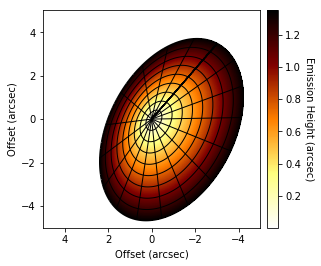

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(np.where(rvals <= 4.5, zvals, np.nan), origin='lower', extent=cube.extent, cmap='afmhot_r')
ax.contour(cube.xaxis, cube.yaxis, rvals, np.arange(0.5, 5.0, 0.5), linewidths=1.0, colors='k')
ax.contour(cube.xaxis, cube.yaxis, np.where(rvals <= 4.5, tvals, np.nan),
           np.linspace(-np.pi, np.pi, 18)[:-1], linewidths=1.0, linestyles='-', colors='k')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Emission Height (arcsec)', rotation=270, labelpad=13)

## Extracing a Disk Averaged Spectrum

Now that we know how to deproject the data, we can use this to map a Keplerian velocity field onto the disk and calculated the projected line of sight velocity, $v_0$, given by,

$$
v_0(r,\,\theta) = \sqrt{\frac{GM_{\rm star}r^2}{(r^2 + z^2)^{3/2}}} \, \cos (\theta) \, \sin (i),
$$

where we are expected to know $M_{\rm star}$ ($0.88~M_{\rm sun}$ for TW Hya), and the distance to the source ($59.5~{\rm pc}$).

To apply this we use the `averaged_spectrum` function, which is provided the geometrical properties of the disk to calculate $v_0$, before applying these shifts to concentric annuli of the data before combining them, weighted by the area of each annulus. We must also tell it what radial range to consider through the `r_min` and `r_max` parameters, both given in arcseconds.

In [16]:
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=1.0, inc=5.0, PA=152., mstar=0.88, dist=59.5, dr_bin=0.1)

Notice the warning above, ``WARNING: Setting `r_min = cube.dpix` for safety.``. This is because we get a singularity at $r = 0$. If you really want to push in as close to the disk center as possible, try `r_min=1e-4`, but be warned, beam convolution effects limit the accuracy of this method in regions closer in than a beam FWHM.

Plotting the data gives a nice spectrum:

(-2537.777807609844, 8217.777746656355)

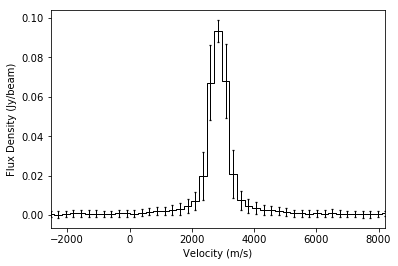

In [18]:
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlim(x[0], x[-1])

Because we end up sampling the line profile at a much higher rate thanks to the Doppler shift of the lines around the azimuth (see the discussion in [Teague et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...868..113T/)), we can resample at a higher rate. This is done through the `resample` parameter. By default this is `resample=1`, so returns the velocity axis attached to the cube.

If the argument is an `int`, then we split the bin into that many channels, while if it is a `float`, then that is the channel spacing. For example:

(1840.0, 3840.0)

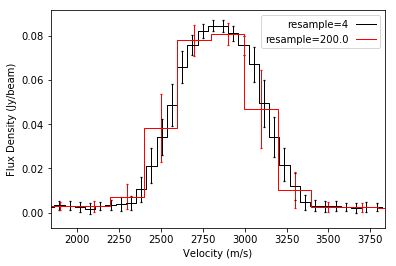

In [22]:
fig, ax = plt.subplots()

# Integeter
x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=4)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0, label='resample=4')

# Float
x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=200.0)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='r', lw=1.0)
ax.step(x, y, where='mid', color='r', lw=1.0, label='resample=200.0')

ax.legend(loc=1, markerfirst=False)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlim(1.84e3, 3.84e3)

Using the argument `unit='K'`, we can also return this in units of Kelvin, using the Rayleigh-Jeans approximation. And note it is exactly that, an approximation, and is a very poor conversion at sub-mm wavelengths, so use with caution!

## Extracted a Disk Integrated Spectrum

In a very similar fashion we can extract a disk integrated spectrum, returning a spectrum in units of Jansky. Again we provide it the inner and outer radii to integrate over.

(1840.0, 3840.0)

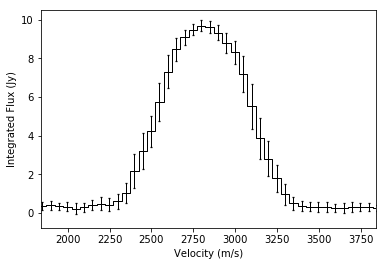

In [26]:
fig, ax = plt.subplots()
x, y, dy = cube.integrated_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                    mstar=0.88, dist=59.5, dr_bin=0.1, resample=50.0)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Integrated Flux (Jy)')
ax.set_xlim(1.84e3, 3.84e3)